In [1]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple

In [2]:
DATA_PATH = './data/'
DATA_SOURCES = ['valve1','valve2','other']


In [3]:
def load_dfs_by_source(data_dir:str,data_source:str)-> pd.DataFrame:
    """
    Load all dfs by source ('valve1','valve2','other')

    Args:
        data_dir (str): _description_
        data_source (str): _description_

    Returns:
        pd.DataFrame: _description_
    """
    all_files=[]
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith(".csv"):
                all_files.append(os.path.join(root, file))
    all_files.sort()
    
    
    dfs_list = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if data_source in file]
    
    return (
        pd.concat(dfs_list)
        # .drop(columns=['changepoint'])
        .sort_index()
    )

def train_val_test_split_original(valve1_data_sets:pd.DataFrame)\
    ->Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Load original lgbm data sets

    Args : valve1_data_set
    
    Returns:
         x_train, x_valid, x_test, y_train, y_valid, y_test 
    """
    #train_pre(valve1_data is dataframe)
    train_pre=valve1_data_sets

    #train_pre ⇒ train:valid_pre=7:3
    train_pre_size=len(train_pre)
    train_size=int(train_pre_size*0.7)
    train=train_pre[0:train_size]
    x_train_pre=train.drop('anomaly',axis=1)
    x_train=x_train_pre.drop('changepoint',axis=1)
    y_train=train['anomaly'].values

    #valid_pre ⇒ valid:test=2:1
    valid_pre_size=train_pre_size-train_size
    valid_size=int(valid_pre_size*0.66)
    valid=train_pre[train_size:train_size+valid_size]
    x_valid_pre=valid.drop('anomaly',axis=1)
    x_valid=x_valid_pre.drop('changepoint',axis=1)
    y_valid=valid['anomaly'].values

    test=train_pre[train_size+valid_size:]
    x_test_pre=test.drop('anomaly',axis=1)
    x_test=x_test_pre.drop('changepoint',axis=1)
    y_test=test['anomaly'].values
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test

def data_perprocessing_original():
    pass

def smooth_curve(x):
    #x=1 dimension array
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5] 

def create_dataset(dataset,look_back=10):
    
    data_X=np.zeros((len(dataset)-look_back+1,3))
    j=0
    
    for i in range(look_back-1,len(dataset)):
        
        data_pre=dataset[i-look_back+1:i+1,0]
    
        data_pre_mean=np.mean(data_pre,axis=0)
        data_pre_min=np.min(data_pre,axis=0)
        data_pre_max=np.max(data_pre,axis=0)
        
        data_X[j,:]=np.array([data_pre_mean,data_pre_min,data_pre_max])
        j+=1
    
    return np.array(data_X).reshape(-1,3) 

In [4]:
data_dict_by_source = {source:load_dfs_by_source(DATA_PATH,source) for source in DATA_SOURCES}

In [5]:
x_train, x_valid, x_test, y_train, y_valid, y_test = train_val_test_split_original(data_dict_by_source['valve1'])

# train_x,train_y,valid_x,valid_y,test_x,test_y = train_val_test_split_original(data_dict_by_source['valve1'])

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


In [35]:
class TargetsWindow(BaseEstimator, TransformerMixin):
    
    def __init__(self,look_back:int=10) -> None:
        self.look_back = look_back
    
    def fit(self, X, y=None):
        return self

    def transform(self, y:np.array):
    
        return pd.Series(y[self.look_back-1:]).to_frame().rename(columns={0:'anomaly'}).values


class SmoothCurve(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X:np.array):
        # Perform arbitary transformation
        X_win=np.zeros_like(X.values)
        data_dim = X.shape[1]
        
        for i in range(0,data_dim):
            X_win[:,i]=smooth_curve(X.values[:,i].flatten())
    
        return X_win


class CreateStatsDataframe(BaseEstimator, TransformerMixin):
    
    stats_cols=['A1_mean','A1_min','A1_max', \
          'A2_mean','A2_min','A2_max', \
          'Cur_mean','Cur_min','Cur_max', \
          'Pre_mean','Pre_min','Pre_max', \
          'Temp_mean','Temp_min','Temp_max', \
          'Ther_mean','Ther_min','Ther_max', \
          'Vol_mean','Vol_min','Vol_max', \
          'Flow_mean','Flow_min','Flow_max']
    
    
    def __init__(self,look_back:int=10) -> None:
        self.look_back = look_back
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        data_dim = X.shape[1]
        for i in range(data_dim):
            if i==0:
                X_win=create_dataset(X[:,i].reshape(-1,1),look_back=self.look_back)
            else:
                X_win =  np.concatenate([X_win,create_dataset(X[:,i].reshape(-1,1),look_back=self.look_back)],axis=-1)
                
        X_win=X_win.reshape(-1,3*data_dim)
        
        df = pd.DataFrame(data=X_win,columns=CreateStatsDataframe.stats_cols)
        
        return df

In [36]:
smooth = SmoothCurve()
scaler = StandardScaler()
df_creator = CreateStatsDataframe(look_back=10)
targets_win = TargetsWindow(look_back=10)

In [37]:
features_pipeline = Pipeline(
    [
        ('smooth',smooth),
        ('scaler',scaler),
        ('df_creator',df_creator)
    ]
)

targets_pipeline = Pipeline([('targets_win',targets_win)])

In [38]:
# features_pipeline.fit_transform(x_train)
targets_pipeline.transform(y_train) 


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [39]:
train_x = features_pipeline.fit_transform(x_train)
train_y = targets_pipeline.transform(y_train)
 
valid_x = features_pipeline.fit_transform(x_valid)
valid_y = targets_pipeline.transform(y_valid) 

test_x = features_pipeline.transform(x_test)
test_y = targets_pipeline.transform(y_test) 

In [40]:
print(test_x.shape ,test_y.shape)

(1844, 24) (1844, 1)


In [41]:
# def calc_metrics(metrics,y_test,y_pred):
#     pass
# def plot_metrics(metrics,metrics_res):
#     pass

# class ModelEvaluation:
    
#     """
#     eval_config = {
#       'lgb' : {
#           'y_test' : pd.Series(),
#           'y_pred': pd.Series()
#       } ,
#       'lgb_new': {
#           'y_test' : pd.Series(),
#           'y_pred': pd.Series()
#       }
# }
#     """
    
#     def __init__(self,eval_config) -> None:
#         self.eval_config = eval_config
        
#     def run(self):
        
#         for model in self.eval_config.keys():
#             pass

In [42]:

# eval_config = {
#     'metrics': [],
#       'lgb' : {
#           'y_test' : pd.Series(),
#           'y_pred': pd.Series()
#       } ,
#       'lgb_new': {
#           'y_test' : pd.Series(),
#           'y_pred': pd.Series()
#       }
# }

# res = {
#     'lgb' : {
#         'cm' : cm,
#         'roc_res' : (fpr, tpr, thresholds),
#         'auc' : roc_auc
#     },
#     'lgb_new': {
#         'cm' : cm,
#         'roc_res' : (fpr, tpr, thresholds),
#         'auc' : roc_auc
#     }
# }

In [43]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
# from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import random
import tensorflow as tf

# fix random seed
tf.random.set_seed(0)
np.random.seed(0)
random.seed(0)
os.environ["PYTHONHASHSEED"] = "0"

#LightGBM train predict function
def lgb_train_predict(x_train,y_train,x_valid,y_valid,x_test,y_test,params, \
                      test_flag=False):
    
    lgb_train=lgb.Dataset(x_train,y_train)
    lgb_valid=lgb.Dataset(x_valid,y_valid)
    lgb_test=lgb.Dataset(x_test,y_test)
    
    model_lgb=lgb.train(params=params,train_set=lgb_train, \
                        valid_sets=[lgb_train,lgb_valid], \
                        )
    
    if test_flag:
        test_pred=np.zeros((len(y_test),1))
        test_pred[:,0]=np.where(model_lgb.predict(x_test)>=0.5,1,0)
        test_acc=accuracy_score(y_test.reshape(-1,1),test_pred)
        test_f1score=f1_score(y_test.reshape(-1,1),test_pred)
        test_cm=confusion_matrix(y_test.reshape(-1,1),test_pred)
        
        return test_acc,test_f1score,test_cm,test_pred,model_lgb
    
    else:
        train_pred=np.zeros((len(y_train),1))
        train_pred[:,0]=np.where(model_lgb.predict(x_train)>=0.5,1,0)
        train_acc=accuracy_score(y_train.reshape(-1,1),train_pred)
        
        valid_pred=np.zeros((len(y_valid),1))
        valid_pred[:,0]=np.where(model_lgb.predict(x_valid)>=0.5,1,0)
        valid_acc=accuracy_score(y_valid.reshape(-1,1),valid_pred) 
        
        return train_acc,valid_acc

/Users/orenben/Documents/runi/mlops-anomaly-detection/.venv/lib/python3.10/site-packages/lightgbm/basic.py:335: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Info] Number of positive: 4309, number of negative: 8395
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 12704, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.339185 -> initscore=-0.666930
[LightGBM] [Info] Start training from score -0.666930
test_acc:0.911062906724512
test_f1score:0.8867403314917127
test_confusionMatrix


array([[1038,    3],
       [ 161,  642]])

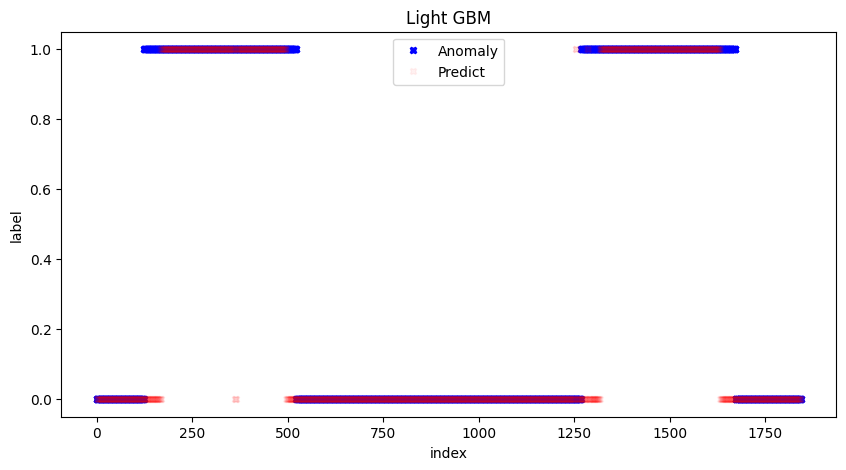

In [44]:

#fine-tunned hyper paramter
lgb_params={'objective':'binary',
            'metric':'binary_error',
            'force_row_wise':True,
            'seed':0,
            'learning_rate':0.0424127,
            'min_data_in_leaf':15,
            'max_depth':24,
            'num_leaves':29
           }

test_acc,test_f1score,test_cm,test_pred,model_lgb=lgb_train_predict(train_x,train_y,valid_x,valid_y,test_x,test_y,params=lgb_params,test_flag=True)

print('test_acc:' + str(test_acc))
print('test_f1score:' + str(test_f1score))
print('test_confusionMatrix')
display(test_cm)

plt.figure(figsize=(10,5))
plt.plot(range(len(test_y)),test_y,linestyle='none', marker='X', color='blue', markersize=5, label='Anomaly')
plt.plot(range(len(test_pred)),test_pred,linestyle='none', marker='X', color='red', markersize=5, label='Predict',alpha=0.05)
plt.title('Light GBM')
plt.xlabel('index')
plt.ylabel('label')
plt.legend(loc='best')